<a href="https://colab.research.google.com/github/RYangData/COMP90024-CCC-notes/blob/master/guides/pdf-rag-nomic-embed-multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Over PDFs with Nomic Embed Multimodal

*   List item
*   List item



![banner image](https://assets.nomicatlas.com/pdf-rag-nomic-embed-multimodal.png)

Nomic Embed Multimodal is an embedding model that processes both text and images. It can directly process the visual content in PDFs without requiring preprocessing steps like OCR or image captioning.

In this notebook, we demonstrate how to build multimodal RAG that can answer questions from PDFs containing both text and visual elements.

**Note: due to the use of Flash Attention in this notebook, compatible GPUs such as the Ampere series (A10, A100, etc) are required. It should cost you < $1 in Colab compute credits on an A100.**

## Setup

Make sure the required libraries are installed. Note that we use the Nomic fork of `colpali` (for compatibility with the new `nomic-embed-multimodal` model).

In [ ]:
!sudo apt-get install --quiet -y poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (262 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 126210 files and direc

In [ ]:
!pip install -q git+https://github.com/nomic-ai/colpali.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils[decord]==0.0.8 accelerate flash-attn matplotlib scikit-learn pdf2image requests

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 108.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
colpali-engine 0.3.9.dev61+g4b681c1 requires transformers<4.50.0,>=4.49.0, but you have transformers 4.51.0.dev0 which is incompatible.


## Prepare PDF Data

We are going to use pdfs of arxiv papers.

In [ ]:
import requests

PDFs = [
    {'title': "Attention Is All You Need", 'file': "https://arxiv.org/pdf/1706.03762"},
    {'title': "Deep Residual Learning", 'file': "https://arxiv.org/pdf/1512.03385"},
    {'title': "BERT", 'file': "https://arxiv.org/pdf/1810.04805"},
    {'title': "GPT-3", 'file': "https://arxiv.org/pdf/2005.14165"},
    {'title': "Adam Optimizer", 'file': "https://arxiv.org/pdf/1412.6980"},
    {'title': "GANs", 'file': "https://arxiv.org/pdf/1406.2661"},
    {'title': "U-Net", 'file': "https://arxiv.org/pdf/1505.04597"},
    {'title': "DALL-E 2", 'file': "https://arxiv.org/pdf/2204.06125"},
    {'title': "Stable Diffusion", 'file': "https://arxiv.org/pdf/2112.10752"}
]

for pdf in PDFs:
    with open(f"{pdf['title']}.pdf", 'wb') as f:
        f.write(requests.get(pdf['file']).content)
    print("saved paper for", pdf['title'])

saved paper for Attention Is All You Need
saved paper for Deep Residual Learning
saved paper for BERT
saved paper for GPT-3
saved paper for Adam Optimizer
saved paper for GANs
saved paper for U-Net
saved paper for DALL-E 2
saved paper for Stable Diffusion


In [ ]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

def display_pdf_images(images_list):
    """Display all images in the provided list as subplots with 5 images per row."""
    num_images = len(images_list)
    num_rows = num_images // 5 + (1 if num_images % 5 > 0 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    if num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    else:
        axes = axes.flatten()
    for i, img in enumerate(images_list):
        if i < len(axes):
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Page {i+1}")
            ax.axis('off')
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

for pdf in PDFs:
    pdf["images"] = convert_from_path(f"{pdf['title']}.pdf")

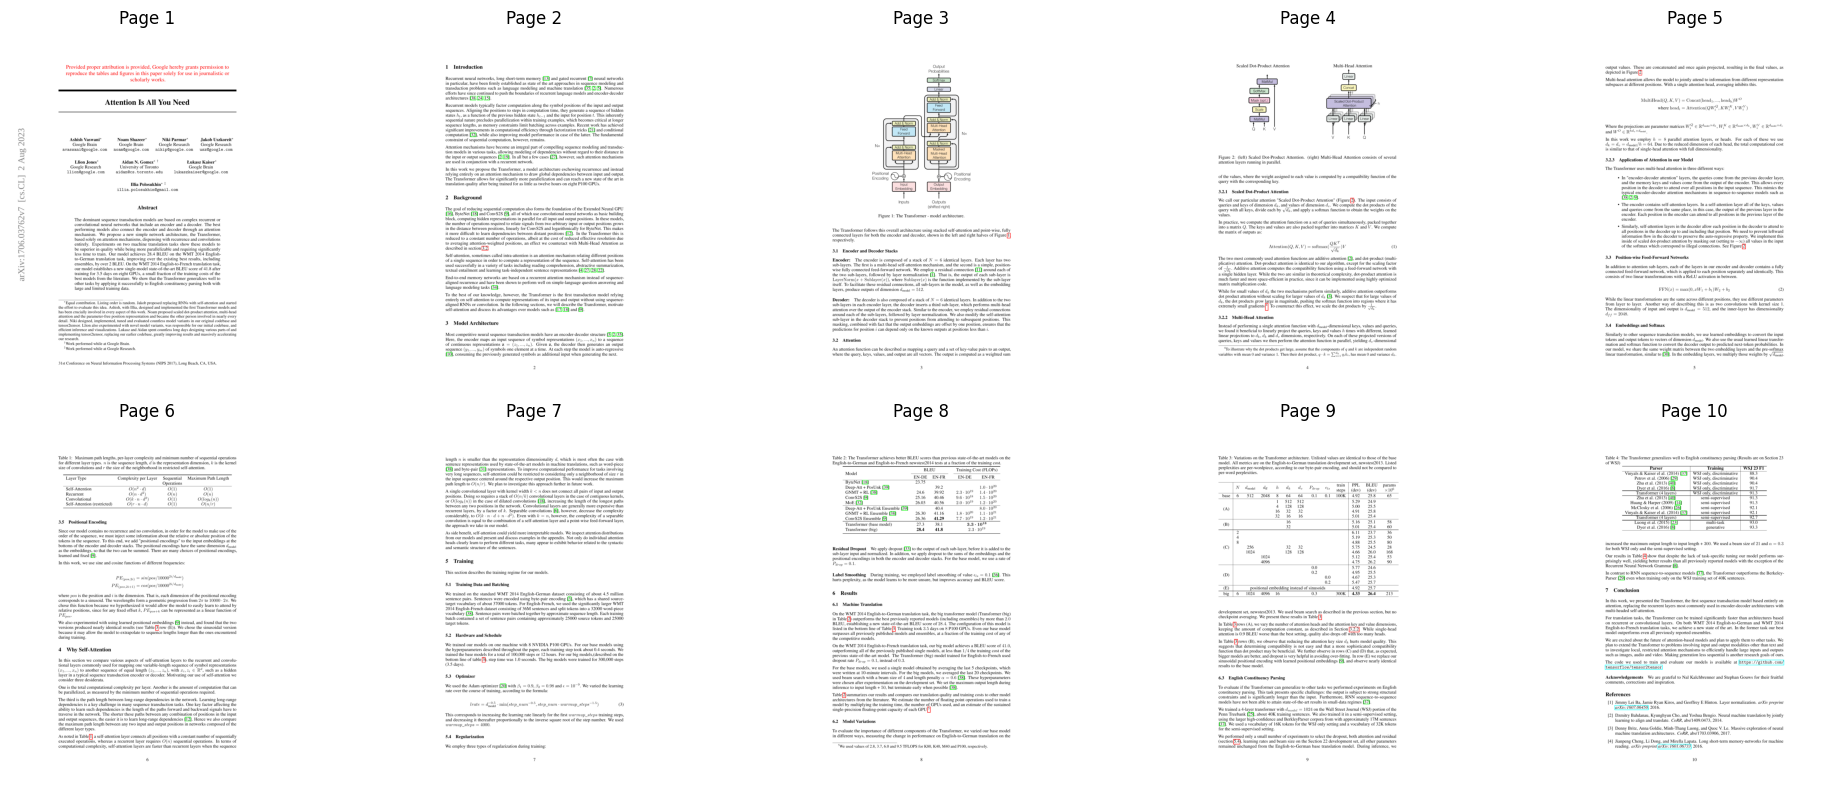

In [ ]:
display_pdf_images(PDFs[0]["images"][:10])

# Embed PDFs

We use Nomic Embed Multimodal to create an embedding for each page of the PDFs. We will use these embeddings to measure which pages are most relevant to the user's query.

In [ ]:
from colpali_engine.models.qwen2_5.biqwen2_5.modeling_biqwen2_5 import BiQwen2_5
from colpali_engine.models.qwen2_5.biqwen2_5.processing_biqwen2_5 import BiQwen2_5_Processor

In [ ]:
import torch

nomic_model = BiQwen2_5.from_pretrained(
    "nomic-ai/nomic-embed-multimodal-3b",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    attn_implementation="flash_attention_2" if torch.cuda.is_available() else None,
).eval()
nomic_processor = BiQwen2_5_Processor.from_pretrained("nomic-ai/nomic-embed-multimodal-3b")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some kwargs in processor config are unused and will not have any effect: max_num_visual_tokens. 


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class PDFImageDataset(Dataset):
    def __init__(self, pdfs_list):
        self.images = []
        self.filenames = []
        for pdf in pdfs_list:
            for i, img in enumerate(pdf["images"]):
                self.images.append(img)
                self.filenames.append(f"{pdf['title']}_page_{i+1}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "image_filename": self.filenames[idx]
        }

pdf_dataset = PDFImageDataset(PDFs)
dataloader = DataLoader(
    pdf_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: nomic_processor.process_images([a["image"] for a in x]),
)

In [ ]:
image_counter = 0
for pdf_idx, pdf in enumerate(PDFs):
    print(f"Generating embeddings for {len(pdf['images'])} pages in {pdf['title']}")
    pdf['page_embeddings'] = []
    batch_size = 4
    for i in range(0, len(pdf["images"]), batch_size):
        batch_images = pdf["images"][i:i+batch_size]
        inputs = nomic_processor.process_images(batch_images)
        inputs = {k: v.to(nomic_model.device) for k, v in inputs.items()}
        with torch.no_grad():
            embeddings = nomic_model(**inputs)
        embeddings = embeddings.cpu()
        embeddings = embeddings / torch.norm(embeddings, dim=1, keepdim=True)
        for j, emb in enumerate(embeddings):
            if i+j < len(pdf["images"]):
                if 'page_embeddings' not in pdf:
                    pdf['page_embeddings'] = []
                pdf['page_embeddings'].append(emb)
                image_counter += 1

print(f"Generated embeddings for {image_counter} PDF pages")

Generating embeddings for 15 pages in Attention Is All You Need
Generating embeddings for 12 pages in Deep Residual Learning
Generating embeddings for 16 pages in BERT
Generating embeddings for 75 pages in GPT-3
Generating embeddings for 15 pages in Adam Optimizer
Generating embeddings for 9 pages in GANs
Generating embeddings for 8 pages in U-Net
Generating embeddings for 27 pages in DALL-E 2
Generating embeddings for 45 pages in Stable Diffusion
Generated embeddings for 222 PDF pages


In [ ]:
import numpy as np

embeddings = np.stack([
    embedding.float().numpy()
    for pdf in PDFs for embedding in pdf["page_embeddings"]
])

data = []
page_count = 0
for pdf in PDFs:
    for page_idx in range(len(pdf["images"])):
        data.append({
            "title": pdf["title"],
            "file": pdf["file"],
            "page_number": page_idx + 1,
            "image": pdf["images"][page_idx],
            "id": page_count
        })
        page_count += 1

## Setup Retrieval and VLM Querying

The `retrieve` function uses the embeddings generated by Nomic Embed Multimodal to retrieve the PDF pages closest to our query.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve(query: str, k: int = 3) -> list:
    """Retrieve semantically similar items from data based on embeddings"""
    query = nomic_processor.process_queries([query])
    with torch.no_grad():
        query = {k: v.to(nomic_model.device) for k, v in query.items()}
        query_embedding = nomic_model(**query).float().cpu().numpy()
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    cos_sim = cosine_similarity(query_embedding, embeddings)[0]
    idx_sorted_by_cosine_sim = np.argsort(cos_sim)[::-1]
    sorted_data = [data[i] for i in idx_sorted_by_cosine_sim]
    return sorted_data[:k]

The `query_image` function uses a vision-language model (VLM) to ask a question of an image, which we will use to answer the user query.

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL.Image import Image

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

def query_vlm(query: str, images: list[Image]) -> str:
    """Queries Qwen VLM with text and images"""
    system_prompt = "You are an expert professional PDF analyst who gives rigorous in-depth answers."
    message_content = [
        {"type": "image", "image": image}
        for image in images
    ] + [{"type": "text", "text": query}]
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        },
        {
            "role": "user",
            "content": message_content
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=1000)
    generated_ids_trimmed = generated_ids[0][len(inputs.input_ids[0]):]
    return processor.decode(generated_ids_trimmed, skip_special_tokens=True)

## Plotting Helper Function

In [ ]:
import textwrap
from matplotlib import gridspec
import numpy as np

def plot_rag_result(query: str, answer: str, images: list[Image]) -> None:
    """Plots user query, retrieved source doc as image(s), and VLM answer"""
    wrapped_query = '\n'.join(textwrap.wrap(query, width=70))
    num_images = len(images)
    fig = plt.figure(figsize=(14, 10))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    if num_images == 1:
        ax1 = fig.add_subplot(outer[0])
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title("Source Document\nretrieved by Nomic Embed Multimodal",
                      fontsize=12, fontweight='bold', loc='left', pad=0)
    else:
        left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
        fig.text(0.1, 0.9, "Source Documents\nretrieved by Nomic Embed Multimodal",
                fontsize=12, fontweight='bold', va='top', ha='left')
        if num_images == 2:
            rows, cols = 1, 2
        else:
            cols = min(int(np.ceil(np.sqrt(num_images))), 3)
            rows = int(np.ceil(num_images / cols))
        inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=left[0],
                                                wspace=0.05, hspace=0.05)
        for i, image in enumerate(images):
            ax_sub = fig.add_subplot(inner[i])
            ax_sub.imshow(image)
            ax_sub.axis('off')
    ax2 = fig.add_subplot(outer[1])
    ax2.axis('off')
    ax2.set_title("Answer generated by Qwen 2.5 VL 7B Instruct", fontsize=12, fontweight='bold', loc='left')
    wrapped_answer = '\n'.join(['\n'.join(textwrap.wrap(line, width=80)) for line in answer.split('\n')])

    # shrink font as text gets longer
    fontsize = min(9, max(4, 9 - ((len(wrapped_answer) - 500) // 1000)))

    ax2.text(0.02, 0.97, wrapped_answer, transform=ax2.transAxes, fontsize=fontsize, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2C3E50', linewidth=2, pad=1.0))
    fig.suptitle(f"Query: {wrapped_query}", fontsize=14, fontweight='bold', y=0.96)
    plt.show()

# Single Document Retrieval

In [ ]:
single_doc_query = "How does the transformer architecture work?"
single_doc_rag_results = retrieve(single_doc_query, k=1)
single_doc_image = single_doc_rag_results[0]["image"]
single_doc_answer = query_vlm(single_doc_query, [single_doc_image])

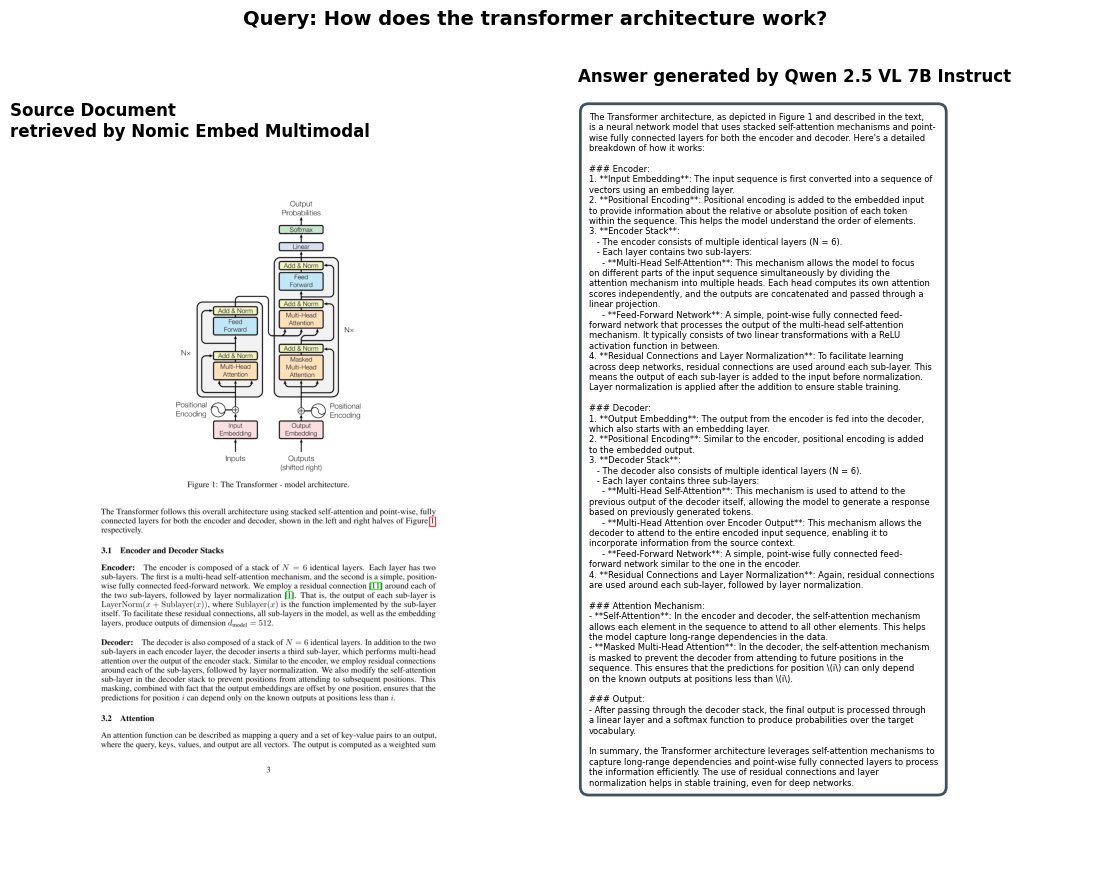

In [ ]:
plot_rag_result(single_doc_query, single_doc_answer, [single_doc_image])

Now we'll display the page in more detail so you can see how the model's answers align with the retrieved source page.

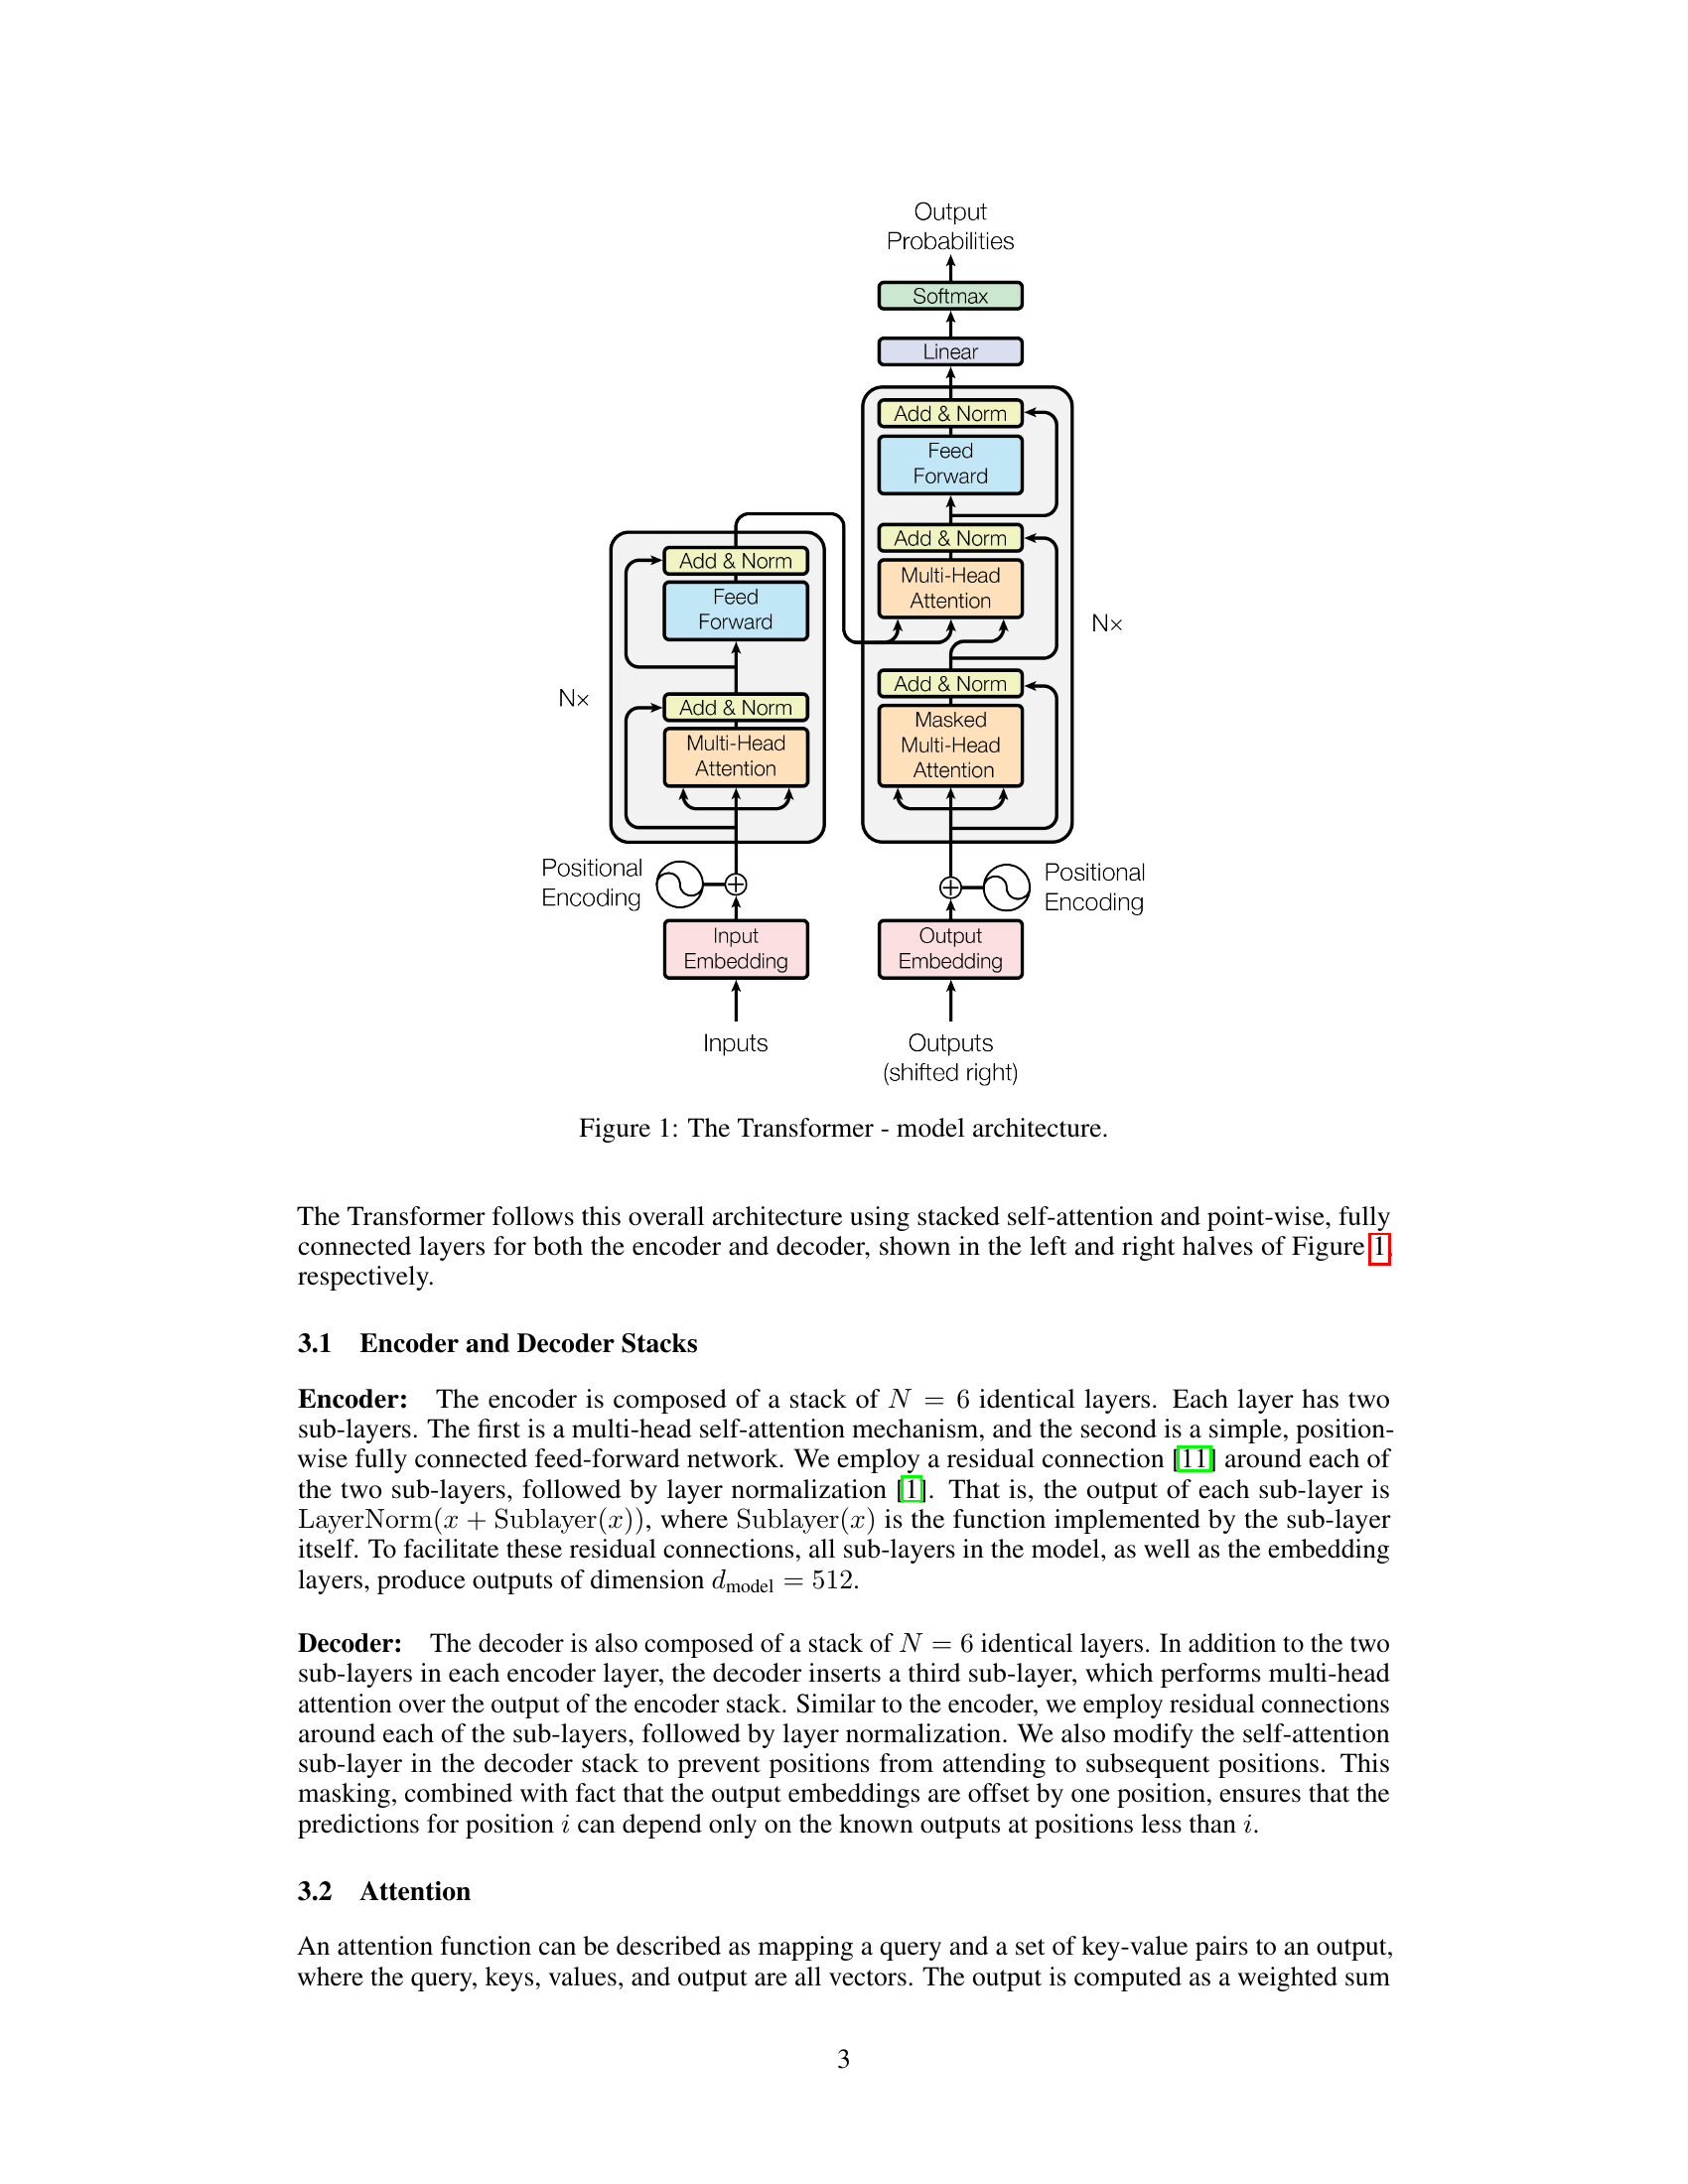

In [ ]:
single_doc_image

In [ ]:
print(single_doc_answer)

The Transformer architecture, as depicted in Figure 1 and described in the text, is a neural network model that uses stacked self-attention mechanisms and point-wise fully connected layers for both the encoder and decoder. Here's a detailed breakdown of how it works:

### Encoder:
1. **Input Embedding**: The input sequence is first converted into a sequence of vectors using an embedding layer.
2. **Positional Encoding**: Positional encoding is added to the embedded input to provide information about the relative or absolute position of each token within the sequence. This helps the model understand the order of elements.
3. **Encoder Stack**:
   - The encoder consists of multiple identical layers (N = 6).
   - Each layer contains two sub-layers:
     - **Multi-Head Self-Attention**: This mechanism allows the model to focus on different parts of the input sequence simultaneously by dividing the attention mechanism into multiple heads. Each head computes its own attention scores independ

# Multi Document Retrieval

In [ ]:
multi_doc_query = "What does the forward pass of a diffusion model look like?"
K = 2
multi_doc_rag_results = retrieve(multi_doc_query, k=K)
multi_doc_images = [x["image"] for x in multi_doc_rag_results]
multi_doc_answer = query_vlm(multi_doc_query, multi_doc_images)

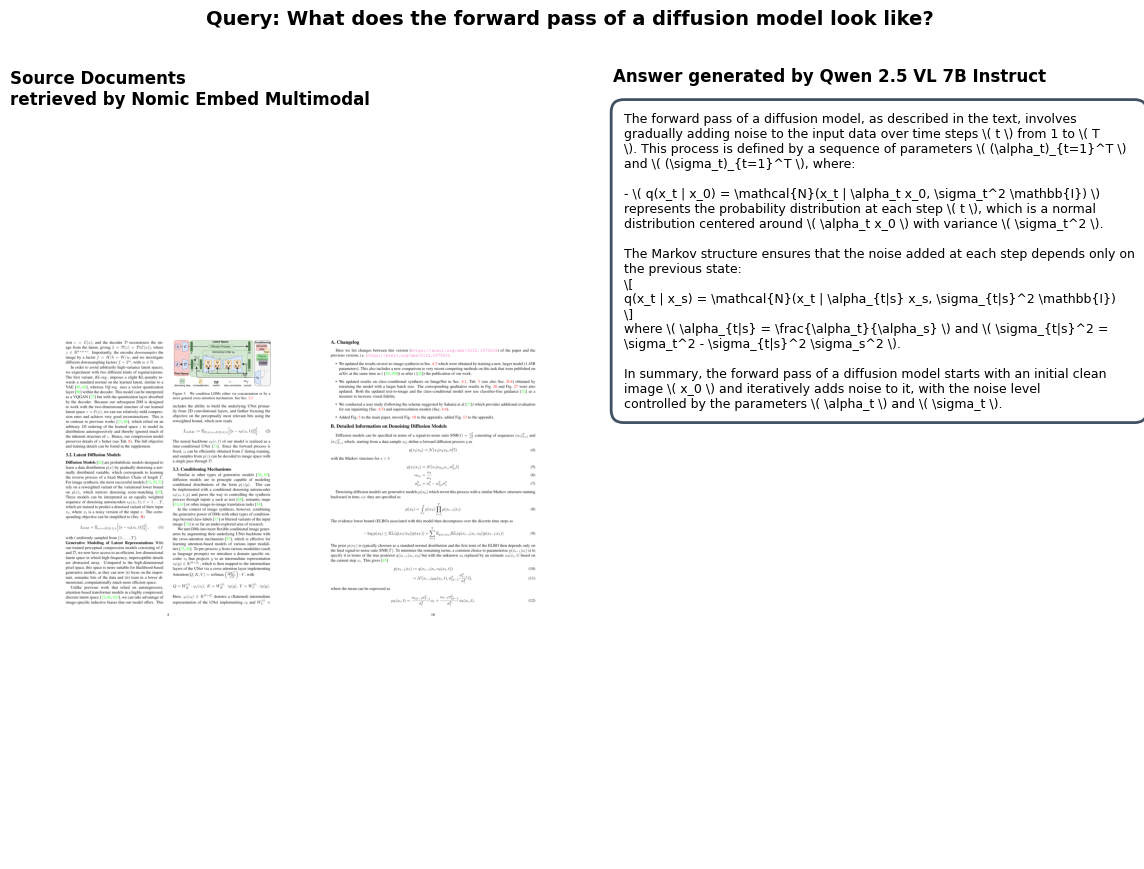

In [ ]:
plot_rag_result(multi_doc_query, multi_doc_answer, multi_doc_images)

Now we'll display the pages in more detail so you can see how the model's answers align with the retrieved source pages.

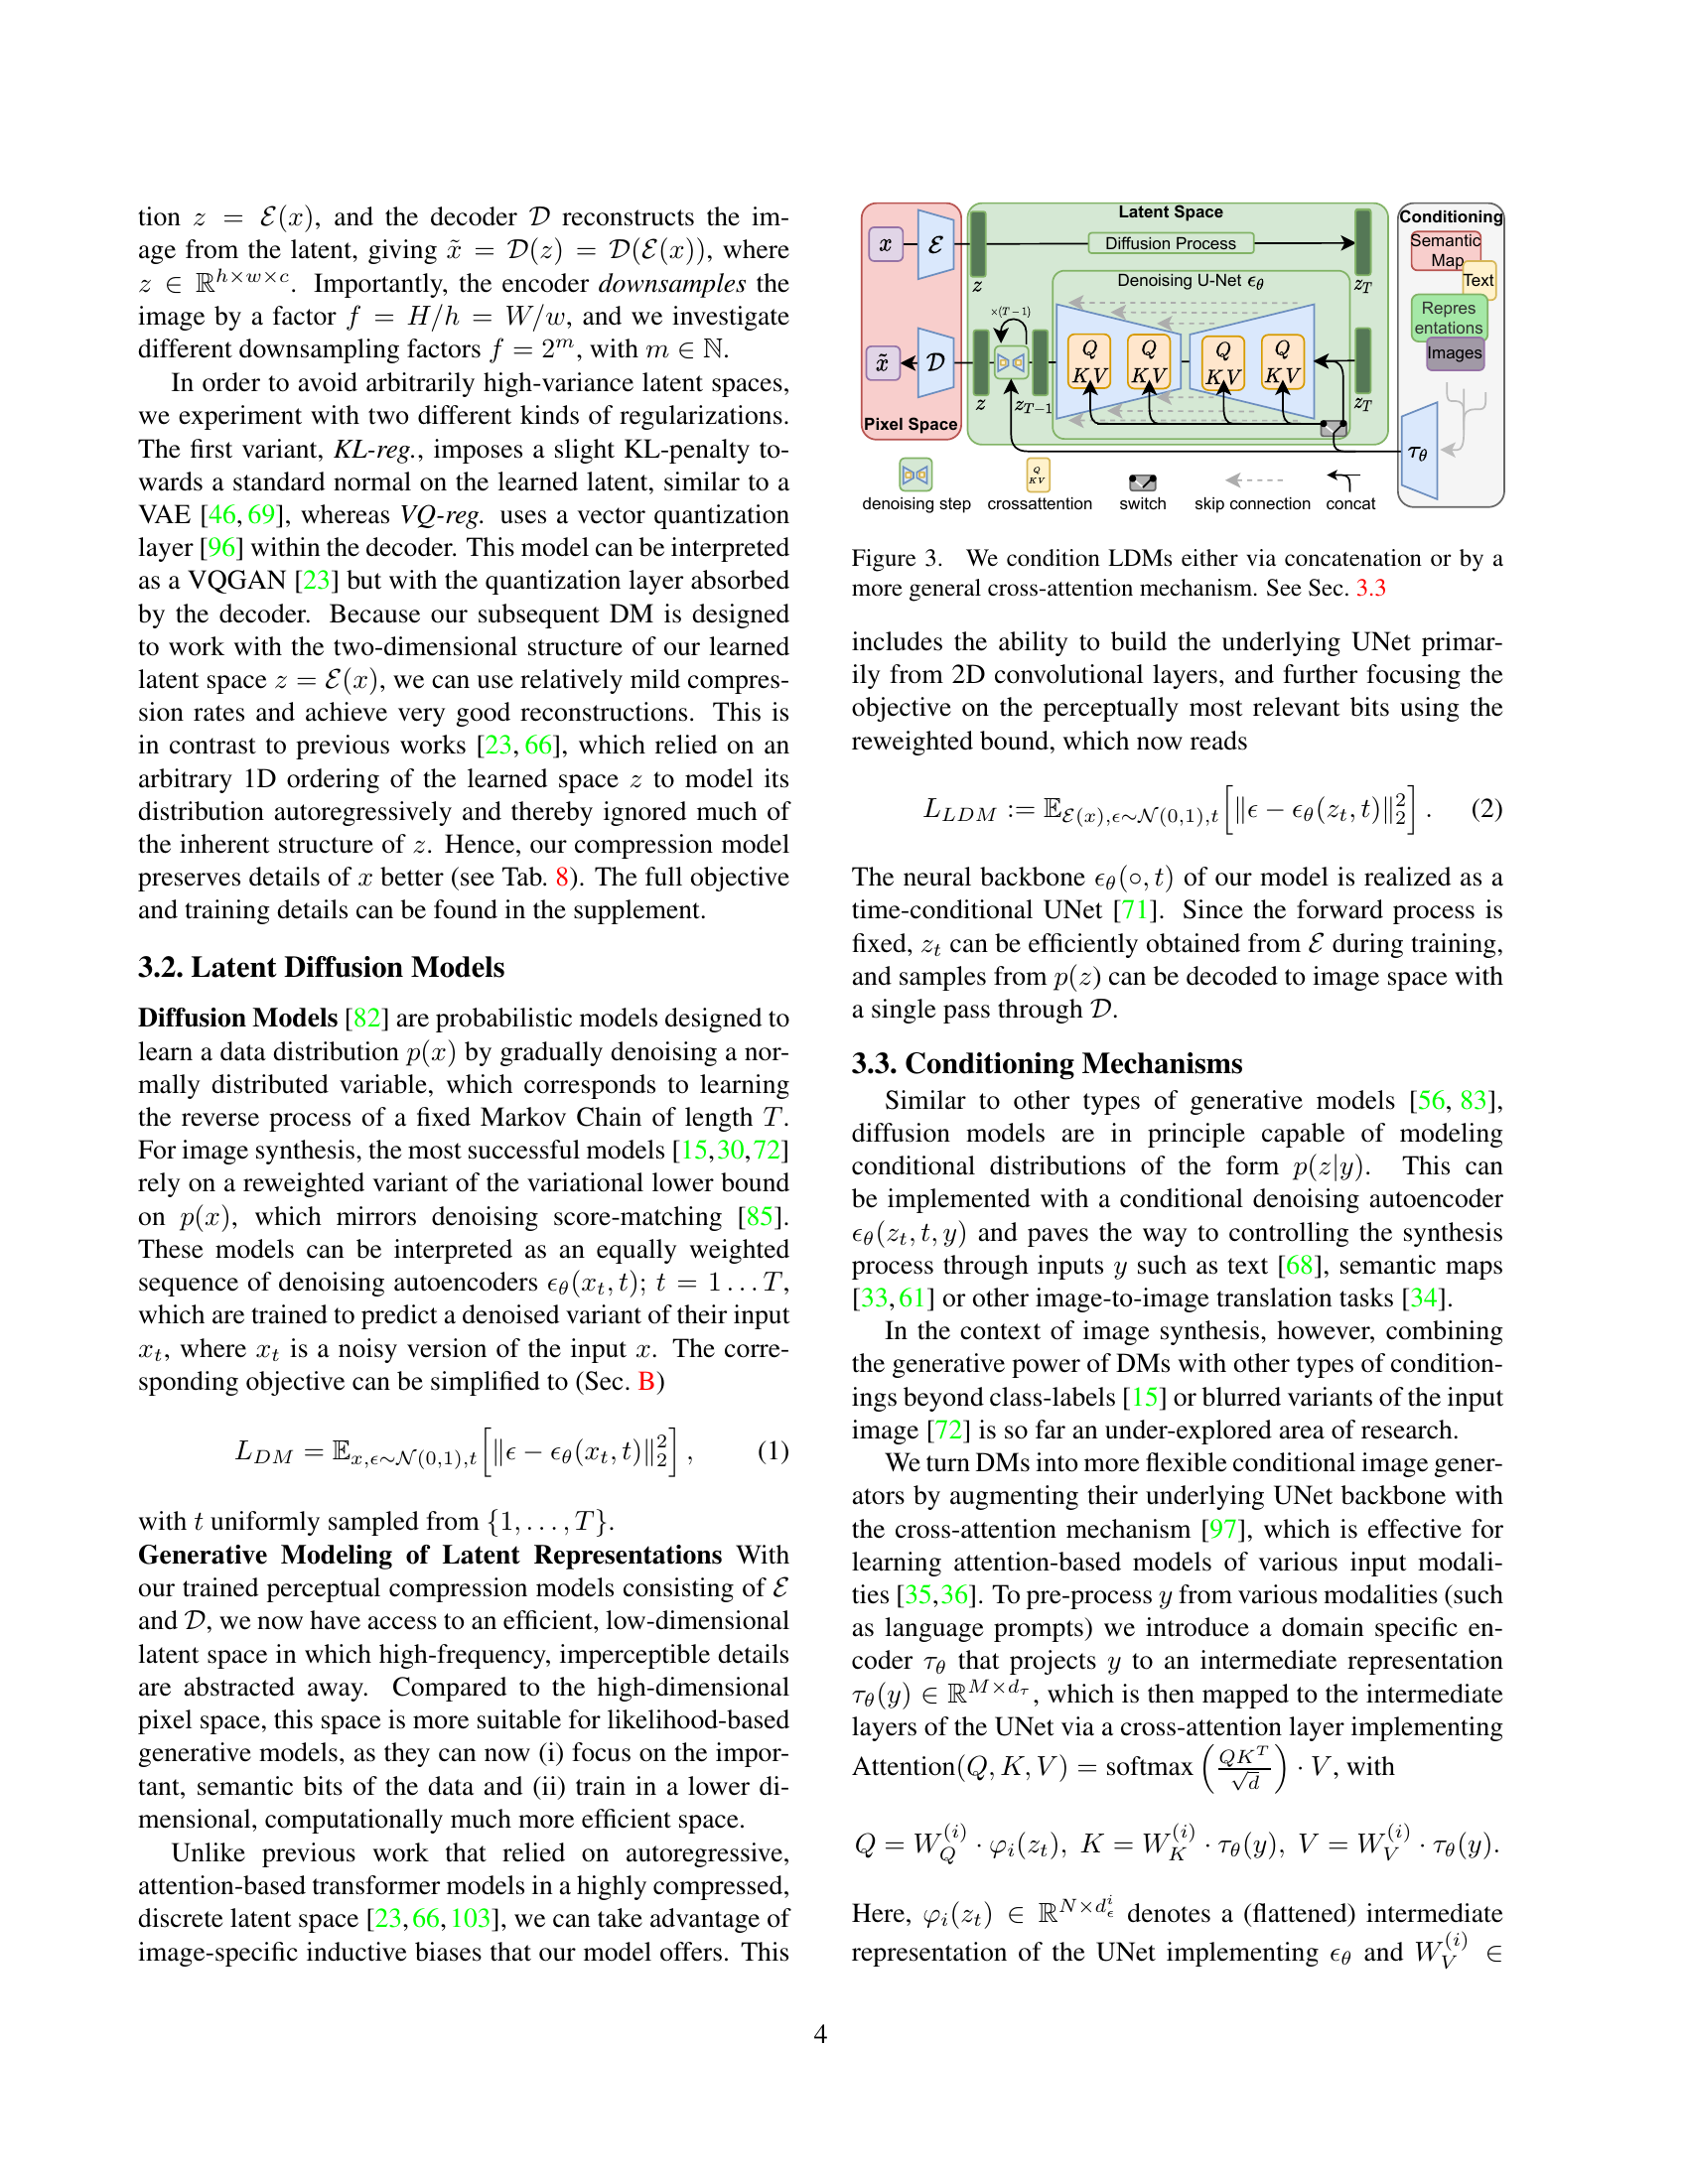

In [ ]:
multi_doc_images[0]

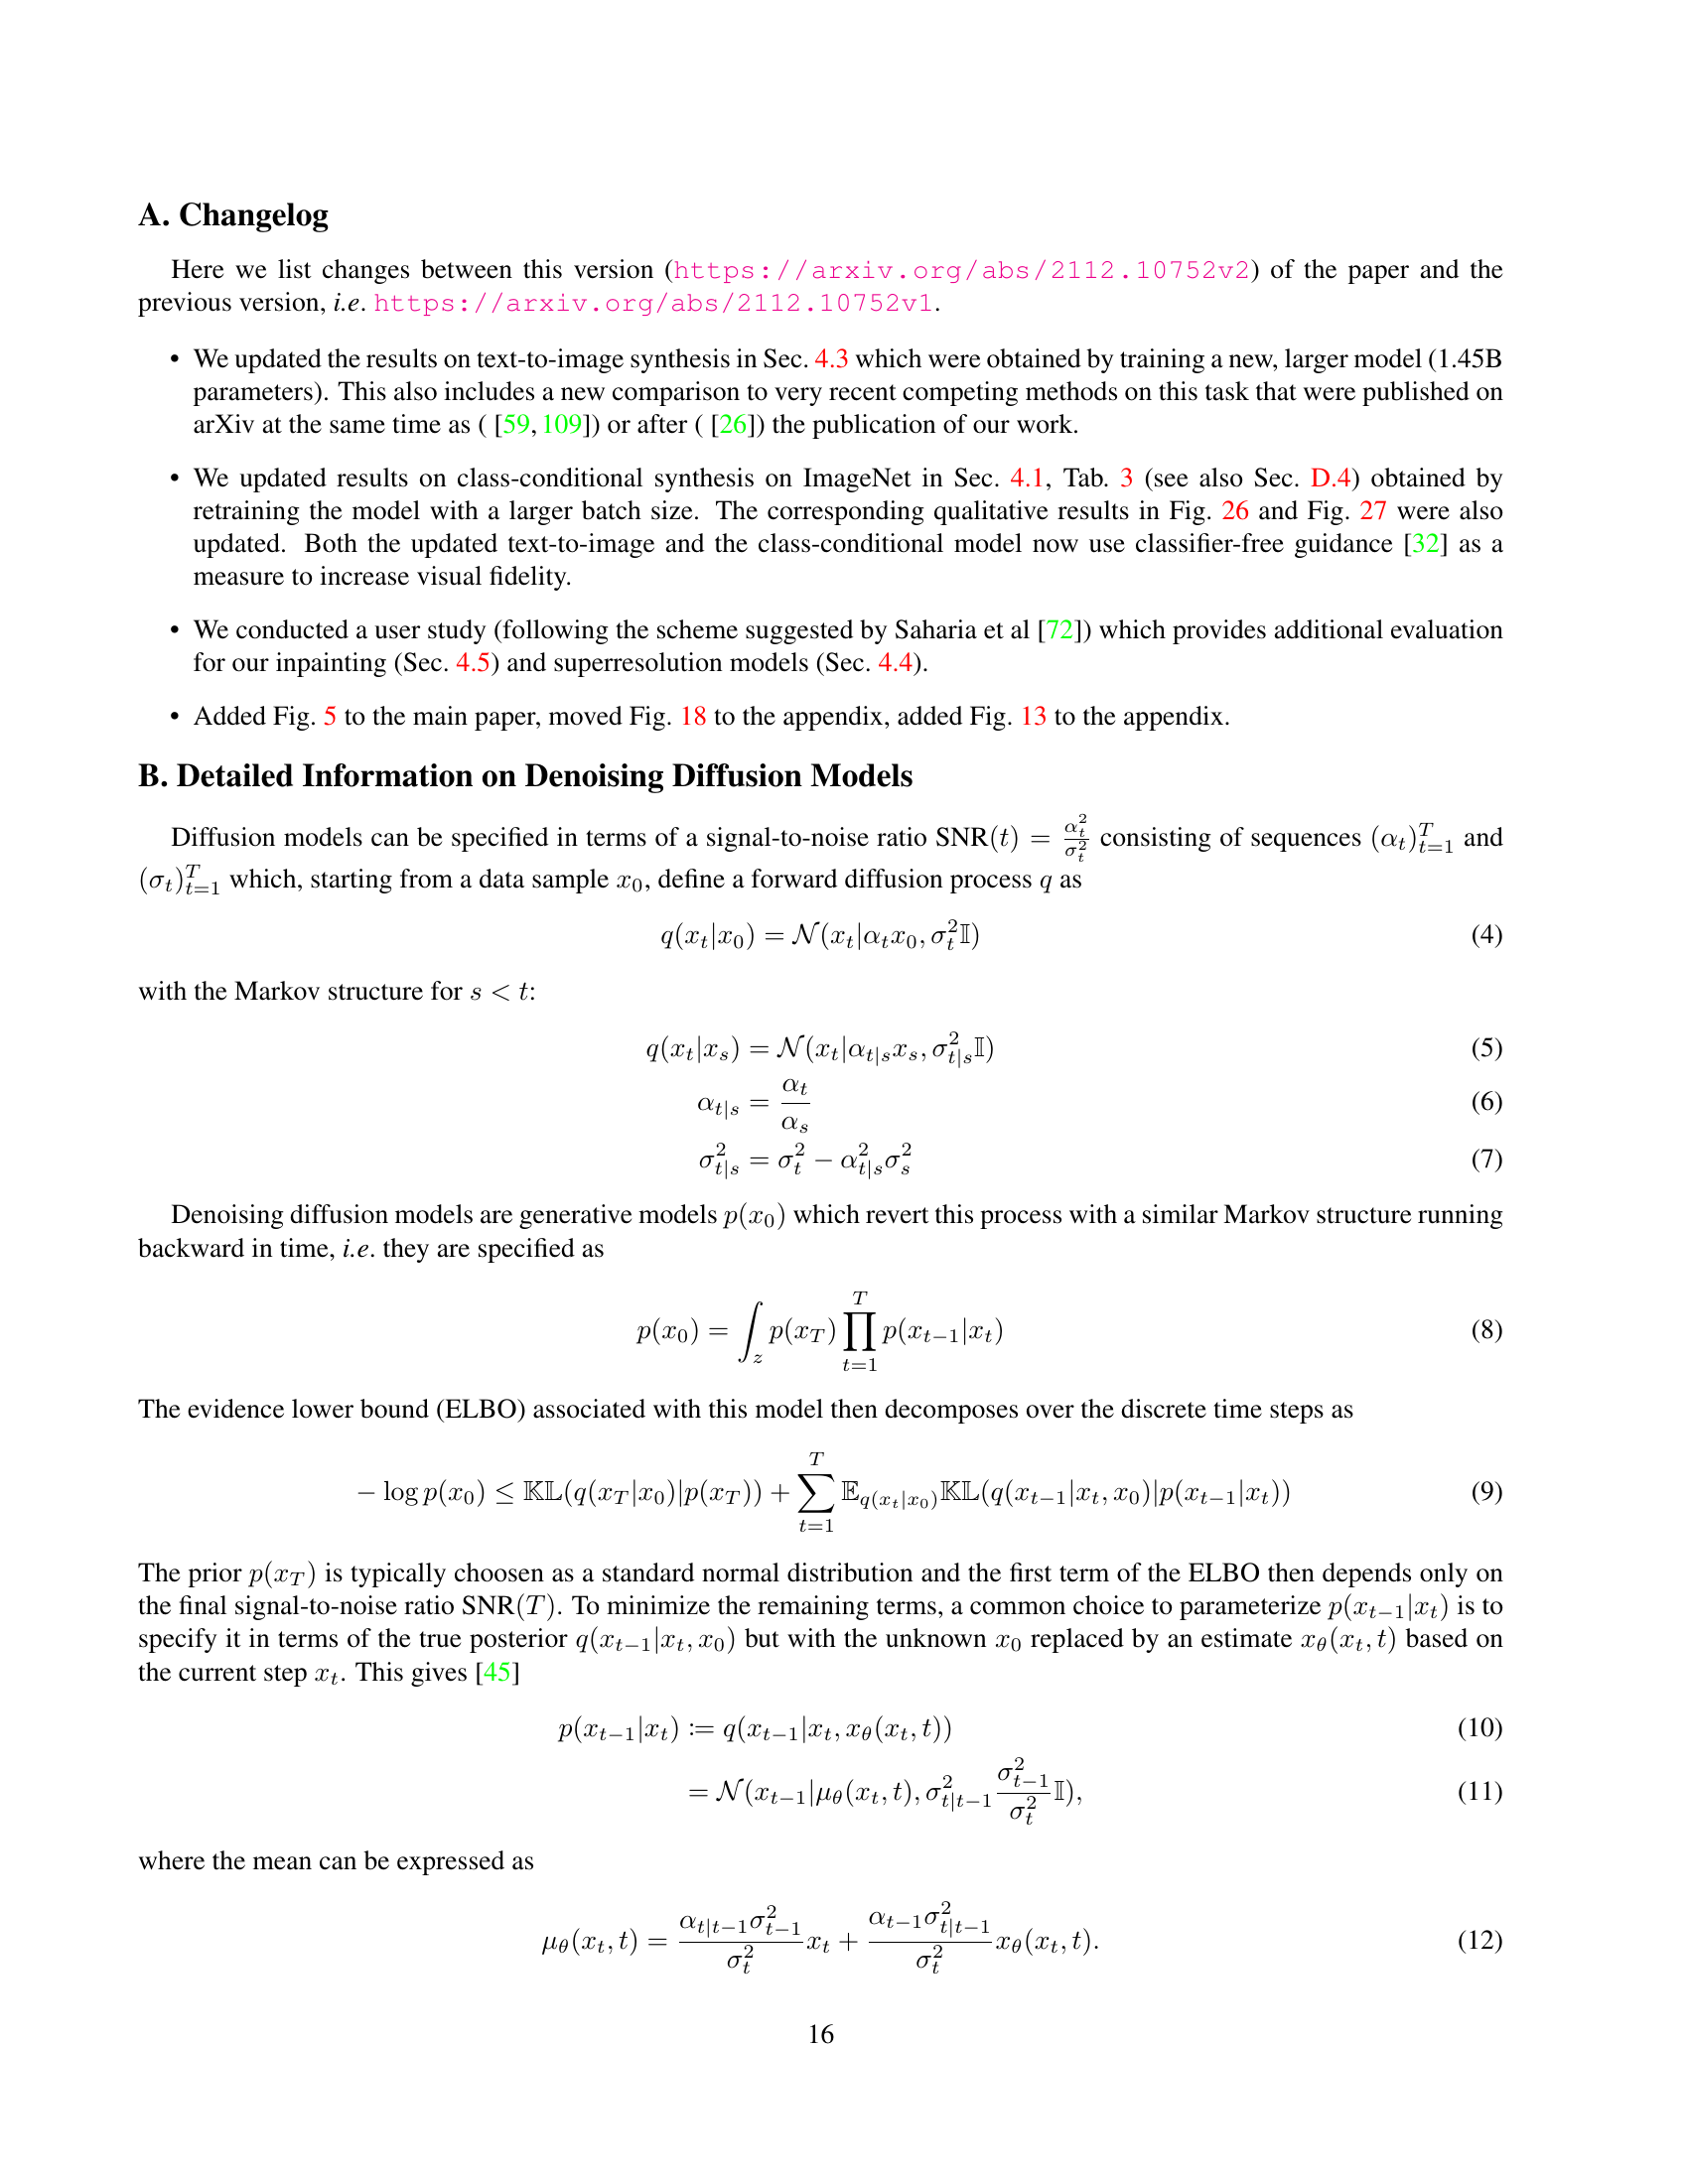

In [ ]:
multi_doc_images[1]

In [ ]:
print(multi_doc_answer)

The forward pass of a diffusion model, as described in the text, involves gradually adding noise to the input data over time steps \( t \) from 1 to \( T \). This process is defined by a sequence of parameters \( (\alpha_t)_{t=1}^T \) and \( (\sigma_t)_{t=1}^T \), where:

- \( q(x_t | x_0) = \mathcal{N}(x_t | \alpha_t x_0, \sigma_t^2 \mathbb{I}) \) represents the probability distribution at each step \( t \), which is a normal distribution centered around \( \alpha_t x_0 \) with variance \( \sigma_t^2 \).

The Markov structure ensures that the noise added at each step depends only on the previous state:
\[
q(x_t | x_s) = \mathcal{N}(x_t | \alpha_{t|s} x_s, \sigma_{t|s}^2 \mathbb{I})
\]
where \( \alpha_{t|s} = \frac{\alpha_t}{\alpha_s} \) and \( \sigma_{t|s}^2 = \sigma_t^2 - \sigma_{t|s}^2 \sigma_s^2 \).

In summary, the forward pass of a diffusion model starts with an initial clean image \( x_0 \) and iteratively adds noise to it, with the noise level controlled by the parameters \( \a